In [1]:
# Imports & utils
import torch
import matplotlib.pyplot as plt

import sys
import os.path as osp
src_path = osp.abspath(osp.join("..", "src"))
if src_path not in sys.path: sys.path.append(src_path)

In [2]:
# Use the chameleon dataset from Wikipedia dataset.
# Symmetrically normalize the transition matrix.
from datasets import load_data, transition_matrix
data = load_data("chameleon", transform=transition_matrix())
data

Data(x=[2277, 3132], edge_index=[2, 65019], y=[2277], train_mask=[2277], val_mask=[2277], test_mask=[2277], edge_attr=[65019])

In [3]:
# Define the GNNGP model.
from gnngp import GNNGP
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GNNGP(data, L=2, sigma_b=0.3, sigma_w=1.0, Nystrom=True, device=device)
# You can also use:
# model = GNNGP(data, device=device)
# model.set_hyper_param(L=2, sigma_b=0.3, sigma_w=1.0, Nystrom=True)

# Using the Nystrom approximation, we need to define the set of landmark nodes.
# Here, we use the training nodes as landmark nodes.
model.mask["landmark"] = model.mask["train"]

model.get_summary()
# Print the hyper parameters.
# By default, GNNGP will use the linear initial kernel and GCN method.

{'L': 2,
 'sigma_b': 0.3,
 'sigma_w': 1.0,
 'Nystrom': True,
 'initial': 'linear',
 'method': 'GCN'}

In [4]:
# Compute the GNNGP Kernel (optional).
# model.predict() will call model.get_kernel().
# Using the Nystrom approximation, the kernel is approximated by a Cholesky style QQ^T.
Q = model.get_kernel()
K = Q @ Q.T
K[:6, :6]

tensor([[1.3036, 0.8407, 0.5434, 0.7778, 0.6467, 0.5471],
        [0.8407, 2.9726, 0.8905, 1.2499, 1.2428, 1.8243],
        [0.5434, 0.8905, 1.1689, 0.8037, 0.6914, 0.5733],
        [0.7778, 1.2499, 0.8037, 2.8985, 0.9476, 0.7920],
        [0.6467, 1.2428, 0.6914, 0.9476, 1.5990, 0.7869],
        [0.5471, 1.8243, 0.5733, 0.7920, 0.7869, 1.1663]])

In [5]:
# Choose a range of epsilon (nugget) values for posterior inference.
# Then fitting data and compute the accuracy in one shot.
# This is enerally faster than loop over all choices of epsilon.
epsilon = torch.logspace(-3, 1, 101, device=model.device)
model.predict(epsilon)

# You can also use:
# from predict import fit_Nystrom, result
# model.fit = fit_Nystrom(Q, model.y, model.mask["train"], epsilon)
# model.result = result(model.fit, model.y, model.mask)
# model.nugget = epsilon

model.get_summary()
# The summary includes only the optimal epsilon (nugget) based on val accuracy.
# To get the fitted value and result metric for all nugget values, use model.fit and model.result.

{'L': 2,
 'sigma_b': 0.3,
 'sigma_w': 1.0,
 'Nystrom': True,
 'initial': 'linear',
 'method': 'GCN',
 'nugget': tensor(0.0331),
 'train': tensor(0.8130),
 'val': tensor(0.6391),
 'test': tensor(0.6852)}

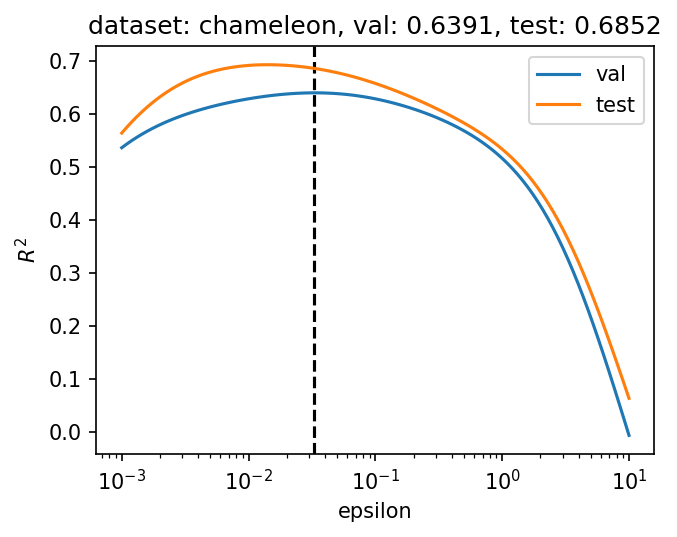

In [6]:
# Visualize the choice of epsilon (nugget)
result = model.result
i = torch.argmax(result["val"])
plt.figure(figsize=(4.8, 3.6), dpi=150)
plt.title("dataset: chameleon, val: %.4f, test: %.4f" % (result["val"][i], result["test"][i]))
plt.axvline(x=epsilon[i], linestyle="--", color="black")
plt.plot(epsilon, result["val"], label="val")
plt.plot(epsilon, result["test"], label="test")
plt.xscale("log"); plt.xlabel("epsilon")
plt.ylabel("$R^2$")
plt.legend()

In [7]:
# Benchmark: GCN

import torch
import torch.nn.functional as F
from torch.nn import BatchNorm1d
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(data.num_features, 256, normalize=False)
        self.conv2 = GCNConv(256, 1, normalize=False)
        self.bn = BatchNorm1d(256)

    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_attr
        x = self.conv1(x, edge_index, edge_weight)
        x = self.bn(x)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index, edge_weight)
        return x

def train():
    model.train()
    optimizer.zero_grad()
    loss = F.mse_loss(model(data)[data.train_mask,0], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

@torch.no_grad()
def test():
    model.eval()
    accs = []
    preds = model(data)[:,0]
    for _, mask in data("train_mask", "val_mask", "test_mask"):
        acc = 1 - torch.sum((preds[mask]-data.y[mask])**2) / torch.sum((data.y[mask]-torch.mean(data.y[mask]))**2)
        accs.append(acc)
    return accs

torch.manual_seed(123)
model = GCN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.3)

for epoch in range(1, 201):
    train()
    train_acc, val_acc, test_acc = test()
    if epoch >= 50 and epoch % 10 == 0:
        print("Epoch: %03d, train: %.4f, val: %.4f, test: %.4f" % 
                (epoch, train_acc, val_acc, test_acc))

Epoch: 050, train: 0.3593, val: 0.2831, test: 0.2771
Epoch: 060, train: 0.4469, val: 0.3843, test: 0.3552
Epoch: 070, train: 0.4672, val: 0.3984, test: 0.3724
Epoch: 080, train: 0.4911, val: 0.4211, test: 0.4007
Epoch: 090, train: 0.5368, val: 0.4705, test: 0.4527
Epoch: 100, train: 0.5517, val: 0.4899, test: 0.4626
Epoch: 110, train: 0.5366, val: 0.4598, test: 0.4644
Epoch: 120, train: 0.5175, val: 0.4340, test: 0.4395
Epoch: 130, train: 0.5433, val: 0.4565, test: 0.4709
Epoch: 140, train: 0.5883, val: 0.5003, test: 0.5062
Epoch: 150, train: 0.5820, val: 0.5069, test: 0.4920
Epoch: 160, train: 0.6264, val: 0.5470, test: 0.5512
Epoch: 170, train: 0.6341, val: 0.5405, test: 0.5589
Epoch: 180, train: 0.6390, val: 0.5460, test: 0.5580
Epoch: 190, train: 0.6572, val: 0.5701, test: 0.5841
Epoch: 200, train: 0.6424, val: 0.5547, test: 0.5658


In [8]:
# Benchmark: GGP kernel

data = load_data("chameleon", transform=transition_matrix(normalization="row"))
params = {"initial":"polynomial", "c":5.0, "d":3.0}
model = GNNGP(data, method="GGP", device=device, **params)
model.predict(epsilon)

model.get_summary()

{'L': 2,
 'sigma_b': 0.1,
 'sigma_w': 1.0,
 'Nystrom': False,
 'initial': 'polynomial',
 'method': 'GGP',
 'nugget': tensor(0.2512),
 'train': tensor(0.7951),
 'val': tensor(0.5411),
 'test': tensor(0.5280)}